<a href="https://colab.research.google.com/github/ThrupthiAnn/CVSummerSchool2021/blob/main/GAN/GAN_CV17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Generative Adversarial Networks

In this lab, we will explore the generative power of GANs and the meaning of the random input we give to the generator. The lab is divided into four experiments:

<ol>
<li> Train and test a GAN </li>
<li> Explore the 'latent variable space' </li>
<li> Arithmetic with latent variables </li>
<li> Using InfoGAN architecture to give meaning to latent variables </li>
</ol>

## 1. Train and test a GAN

First, let us try to train a GAN using some training images and observe the images generated by the generator. 

### Loading the dataset

For this experiment, we are using MNIST dataset. To load the dataset, we will use the  <a href=https://github.com/pytorch/vision/tree/master/torchvision>torchvision</a> package. Notice that we are transforming the images to 64x64, because that is what is required by the network.

In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [transforms.Scale(64),
     transforms.CenterCrop(64),
        transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root='./data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


MNIST dataset is a dataset of handwritten digits. We will train a network that can generate handwritten digits similar to MNIST dataset. Here are some functions that will help us to see the images: Let us see the kind of images in MNIST:

In [40]:
%matplotlib inline

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def imshow_array(img):
    plt.imshow(np.transpose(img, (1,2,0)))

Let us use those functions to explore the MNIST dataset. We will display some random images and their classes:

tensor([8, 2, 6, 1])


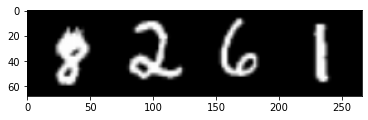

In [41]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(labels)

### Define the Generator network

A generative adversarial network consists of a generator network, which generates images and a discriminator network, which determines if the generated image is real(from the database) or fake(generated). The job of the generator is to fool the discriminator into thinking the generated images are the real ones. It does this by bringing the generated images close to the images in the dataset.

We will use the DCGAN architecture from <a href=https://github.com/pytorch/examples/blob/master/dcgan/main.py>here</a>.

Let us define some parameters and initialize the weights:

In [42]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from collections import namedtuple

# let us define some parameters
workers = 2
batchSize=4
imageSize=28 #height/width of image
nz=10
ngf = 64
ndf=64
niter=1 #number of epochs
lr=0.0002 #learning rate
beta1=0.5 #beta1 for adam
cuda=True
ngpu=1 #number of gpus to use
outf = './output'
manualSeed = 67
nc = 1 #number of channels

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Here, we define the generator network:

In [43]:
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
             nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

Initialize the generator network:

In [44]:
netG = _netG(ngpu)
netG.apply(weights_init)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

Let us see what sort of images are generated by netG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 64, 64])


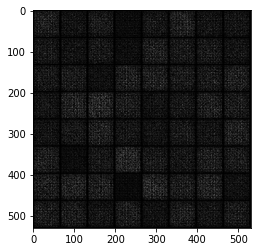

In [45]:
nbatchSize = 64
noise = torch.FloatTensor(nbatchSize, nz,1,1)
noise.normal_(0,1)
noise = Variable(noise)
#noise = noise.cuda()
output = netG.forward(input=noise)
print(output.size())

output = output.cpu()
output = output.data
output = torchvision.utils.make_grid(output)
output = output.permute(1,2,0)
plt.imshow(output.numpy())

The images generated are random, as the generator is not trained.

### Define the discriminator network

Let us now define the discriminator network. We have also defined a criterion as binary cross entropy criterion. This will give us our loss value.

In [46]:
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1)
    
netD = _netD(ngpu)
netD.apply(weights_init)
print(netD)

criterion = nn.BCELoss()

_netD(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Train the network

For training the GAN, we use ADAM optimiser. Here, we set it up.

In [47]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Let us train the network. First we will convert the networks into cuda so that it can run on gpu.

In [48]:
input = torch.FloatTensor(batchSize, 1, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

if cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

The block below trains for 100 batches and prints some images generated by the generator. We can see how the images progress by repeatedly running this block:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


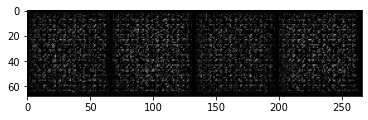

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


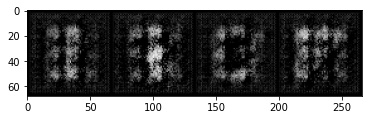

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


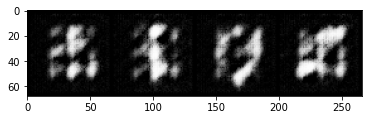

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


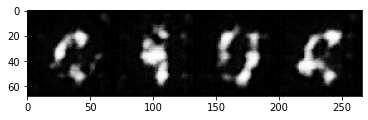

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


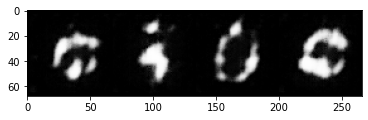

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


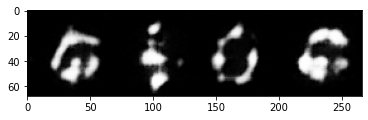

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


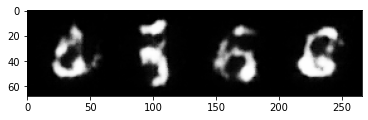

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


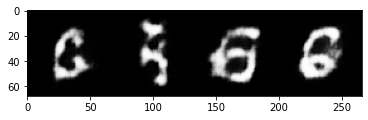

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


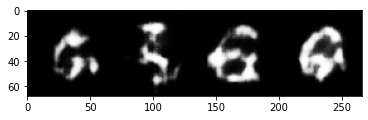

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


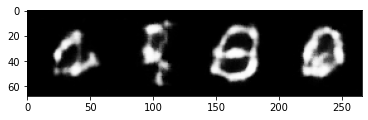

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


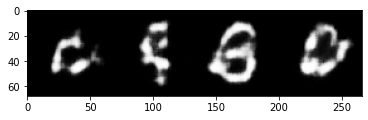

done 100 iterations


In [49]:
for epoch in range(niter):
    for i, data in enumerate(trainloader, 0):
        if i>1000:
            print('done 100 iterations')
            break
            
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output.squeeze(1), labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output.squeeze(1), labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output.squeeze(1), labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        # display some generated images for each 200 iterations
        if i%100 == 0:
            fake = netG(fixed_noise)
            fake = fake.data
            fake = fake[0:16,:,:,:]
            fake = fake.cpu()
            fake = torchvision.utils.make_grid(fake)
            fake = fake.permute(1,2,0)
            plt.imshow((fake.numpy()*255).astype(int))
            plt.show()


Now, we can run it for more iterations to train the network. 

### Walk through the latent variable space
What is the input to the generator and how does it influence the output? Right now, we are giving it random vectors of size 10. Let us see what this vector means. We will slowly change the vector and see how the generated images change.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 64, 64])


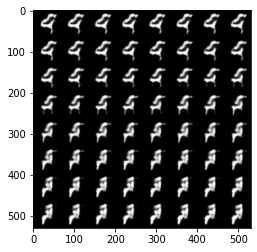

In [50]:
noise = torch.Tensor(nbatchSize, nz, 1,1)
noiseL = torch.FloatTensor(nz).uniform_(-1, 1)
noiseR = torch.FloatTensor(nz).uniform_(-1, 1)
#do a linear interpolation in Z space between point A and point B
#each sample in the mini-batch is a point on the line
line  = torch.linspace(0, 1, nbatchSize)

# print(noiseL.shape, noise.select(0,0).squeeze().shape)
for i in range(0, nbatchSize):
    z = noiseL * line[i] + noiseR * (1 - line[i])
    noise.select(0, i).copy_(z.view(10,1,-1))

noise = Variable(noise)
noise = noise.cuda()
output = netG.forward(input=noise)
print(output.size())

output = output.cpu()
output = output.data
output = torchvision.utils.make_grid(output)
output = output.permute(1,2,0)
plt.imshow(output.numpy())
plt.show()

#### References
<ol>
<li>Pytorch tutorial: http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html</li>
<li>Code: https://github.com/pytorch/examples/tree/master/dcgan</li>
<li>DCGAN paper: Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).</li>
</ol>